In [211]:
import glob
from scipy import ndimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from keras.utils import np_utils

In [194]:
dataList = []
for num in range(1,9): 
    image = ndimage.imread('data/{}.png'.format(num), mode="RGB")
    dataList.append(image)
X = np.array(dataList)
Y = MultiLabelBinarizer().fit_transform([[1],[2],[3],[4],[5],[6],[7],[8]])

/Users/raynem_0/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [195]:
X.shape, Y.shape

((8, 100, 100, 3), (8, 8))

In [196]:
IMAGE_SIZE = 100 

def central_scale_images(X_imgs, scales):
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data

X_scaled = central_scale_images(X, [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5])
Y_scaled = np.repeat(Y, 7, axis=0)

In [197]:
X_scaled.shape, Y_scaled.shape

((56, 100, 100, 3), (56, 8))

In [198]:
from math import ceil, floor

def get_translate_parameters(index):
    if index == 0: 
        offset = np.array([0.0, 0.15], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.85 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.85 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1:
        offset = np.array([0.0, -0.15], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.85 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.85) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: 
        offset = np.array([0.15, 0.0], dtype = np.float32)
        size = np.array([ceil(0.85 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.85 * IMAGE_SIZE)) 
    else: 
        offset = np.array([-0.15, 0.0], dtype = np.float32)
        size = np.array([ceil(0.85 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.85) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), 
               dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
            w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

X_translated = translate_images(X)
Y_translated = []
for i in range(4):
    Y_translated.extend(np.copy(Y))
Y_translated = np.array(Y_translated)

In [199]:
X_translated.shape, Y_translated.shape

((32, 100, 100, 3), (32, 8))

In [200]:
from math import pi

def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * pi / 180  # Convert to radian
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

X_rotate = rotate_images(X, -50, 50, 16)
Y_rotate = []
for i in range(16):
    Y_rotate.extend(np.copy(Y))
Y_rotate = np.array(Y_rotate)

In [201]:
X_rotate.shape, Y_rotate.shape

((128, 100, 100, 3), (128, 8))

In [202]:
def add_salt_pepper_noise(X_imgs):
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.4
    amount = 0.009
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy
  
X_salt_pepper_noise = add_salt_pepper_noise(X)
Y_salt_pepper_noise = np.copy(Y)

In [203]:
X_salt_pepper_noise.shape, Y_salt_pepper_noise.shape

((8, 100, 100, 3), (8, 8))

In [204]:
X = np.concatenate((X, X_scaled, X_translated, X_rotate, X_salt_pepper_noise))
Y = np.concatenate((Y, Y_scaled, Y_translated, Y_rotate, Y_salt_pepper_noise))

In [205]:
X.shape, Y.shape

((232, 100, 100, 3), (232, 8))

In [206]:
X = np.repeat(X, 20, axis=0)
Y = np.repeat(Y, 20, axis=0)

In [207]:
X.shape, Y.shape

((4640, 100, 100, 3), (4640, 8))

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
   
X = rgb2gray(X)    

In [209]:
X.shape

(4640, 100, 100)

In [210]:
X = X.reshape(X.shape[0], 10000)
X = X.astype('float32')
X /= 255 

In [177]:
train_size = int(X.shape[0] * 0.67)
indices = np.random.RandomState(seed=4).permutation(X.shape[0])
training_idxy, test_idxy = indices[:train_size], indices[train_size:]
X_train, X_test = X[training_idxy,:], X[test_idxy,:]
Y_train, Y_test = Y[training_idxy,:], Y[test_idxy,:]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3108, 10000), (1532, 10000), (3108, 8), (1532, 8))

In [178]:
label_dict = {
 0: '1',
 1: '2',
 2: '3',
 3: '4',
 4: '5',
 5: '6',
 6: '7',
 7: '8',
}

Text(0.5,1,'(Label: 1)')

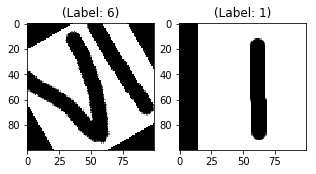

In [179]:
plt.figure(figsize=[5,5])

plt.subplot(121)
curr_img = np.reshape(X_train[1001], (100,100))
curr_lbl = np.argmax(Y_train[1001,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplot(122)
curr_img = np.reshape(X_test[1001], (100,100))
curr_lbl = np.argmax(Y_test[1001,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [180]:
train_X = X_train.reshape(-1, 100, 100, 1)
test_X = X_test.reshape(-1,100,100,1)

In [181]:
train_X.shape, test_X.shape

((3108, 100, 100, 1), (1532, 100, 100, 1))

In [182]:
train_y = Y_train
test_y = Y_test

In [183]:
train_y.shape, test_y.shape

((3108, 8), (1532, 8))

In [184]:
training_iters = 10
learning_rate = 0.001 
batch_size = 128
n_input = 100
n_classes = 8

In [185]:
x = tf.placeholder("float", [None, 100,100,1])
y = tf.placeholder("float", [None, n_classes])

In [186]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [187]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(8), initializer=tf.contrib.layers.xavier_initializer()),
}

In [188]:
def conv_net(x, weights, biases):  
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=4)
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k=4)
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1) 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [189]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [190]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [191]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [192]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    #summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    saver = tf.train.import_meta_graph('model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
#     for i in range(training_iters):
#         for batch in range(len(train_X)//batch_size):
#             batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
#             batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
#             opt = sess.run(optimizer, feed_dict={x: batch_x,
#                                                               y: batch_y})
#             loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
#                                                               y: batch_y})
#         print("Iter " + str(i) + ", Loss= " + \
#                       "{:.6f}".format(loss) + ", Training Accuracy= " + \
#                       "{:.5f}".format(acc))
#         print("Optimization Finished!")

        
#         test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
#         train_loss.append(loss)
#         test_loss.append(valid_loss)
#         train_accuracy.append(acc)
#         test_accuracy.append(test_acc)
#         print("Testing Accuracy:","{:.5f}".format(test_acc))
    #save_path = saver.save(sess, "model.ckpt")
    #summary_writer.close()
    pred = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
    print(pred)

KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [ ]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show()